In [1]:
# # uncomment if running in colab
# # install the github repo https://github.com/Edogor/GPT_from_scratch.git
# !git clone https://github.com/Edogor/GPT_from_scratch.git
# # change to repo dir and install requirements
# %cd /content/GPT_from_scratch/
# %pip install -r requirements.txt
# # download and prep preprocess data
# !python ./data/clean_nltk_shakespear_data_w_nl.py
# # change to notebooks dir
# %cd /content/GPT_from_scratch/notebooks/
# %pwd .

## imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F    
from torch.optim import AdamW
from torch.amp import GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from functools import partial

import json
import os

CHECKPOINT_DIR = os.path.join("..", "checkpoints", "GPT")
LOG_DIR = os.path.join("..", "logs", "GPT")
RESULTS_DIR = os.path.join("..", "results", "GPT")

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [2]:
# add parent directory to the path to allow imports
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from GPT_mj import GPT, ConfigGPT
from train_mj import train, evaluate, ConfigTrain
from utils import init_dataloader, WarmupThenCosine, set_seed, count_params, save_checkpoint, load_checkpoint
from bpe_hf import train_bytelevel_bpe, load_tokenizer, TOK_SPECIAL_TOKENS, TOK_SAVE_DIR

## load data

In [3]:
data_dir = "../data/"
# without nl
# train_file = "Shakespeare_clean_train.txt"
# val_file = "Shakespeare_clean_valid.txt"
# test_file = "Shakespeare_clean_test.txt"
# with nl
train_file = "Shakespeare_clean_w_nl_train.txt"
val_file = "Shakespeare_clean_w_nl_valid.txt"
test_file = "Shakespeare_clean_w_nl_test.txt"

train_file = os.path.join(data_dir, train_file)
test_file = os.path.join(data_dir, test_file)
val_file = os.path.join(data_dir, val_file)

with open(train_file, "r", encoding="utf-8") as f:
    train_text = f.read().strip()

with open(val_file, "r", encoding="utf-8") as f:
    val_text = f.read().strip()

with open(test_file, "r", encoding="utf-8") as f:
    test_text = f.read().strip()

print("train text charachters length: ", len(train_text))
print("train text words count: ", len(train_text.split()))
print("train text first 100 chars: ", train_text[:100])

train text charachters length:  883046
train text words count:  158364
train text first 100 chars:  The Tragedy of Antony and Cleopatra


Dramatis Personae



MARK ANTONY
OCTAVIUS CAESAR
M. AEMILIUS L


## initialize tokensizer and data embeddings

In [5]:
N_MERGES = 800
MIN_FREQ = 2

SPECIAL_TOKENS = TOK_SPECIAL_TOKENS.copy()
PAD_TOKEN = SPECIAL_TOKENS.get("pad", "<pad>")
BOS_TOKEN = SPECIAL_TOKENS.get("bos", "<bos>")
EOS_TOKEN = SPECIAL_TOKENS.get("eos", "<eos>")

tok_name = f"bpe_GPT_{N_MERGES}.json"
tok_dir = TOK_SAVE_DIR
bpe_tokenizer = train_bytelevel_bpe(files=[train_file],
                                merges=N_MERGES, 
                                min_frequency=MIN_FREQ,
                                special_tokens=SPECIAL_TOKENS,
                                lowercase=False,
                                add_prefix_space=True,
                                save_filename=tok_name,
                                save_dir=tok_dir)

encode = partial(bpe_tokenizer.encode, add_special_tokens=False)
decode = bpe_tokenizer.decode
vocab_size = bpe_tokenizer.get_vocab_size()
print("vocab size: ", vocab_size)
print("BPE tokenizer vocab: ", list(bpe_tokenizer.get_vocab().items())[:100])

PAD_TOKEN_ID = bpe_tokenizer.token_to_id(PAD_TOKEN) 
BOS_TOKEN_ID = bpe_tokenizer.token_to_id(BOS_TOKEN)
EOS_TOKEN_ID = bpe_tokenizer.token_to_id(EOS_TOKEN)

train_ids = encode(train_text).ids
test_ids = encode(test_text).ids
val_ids = encode(val_text).ids

print("train ids length: ", len(train_ids))
print("train ids first 100 ids: ", train_ids[:25])
print("train ids first 100 individual tokens: ", [bpe_tokenizer.id_to_token(i) for i in train_ids[:25]]) 

vocab size:  1060
BPE tokenizer vocab:  [('®', 110), ('Ġcomp', 1059), ('s', 86), ('³', 115), ('ĠPORTIA', 884), ('Ġtime', 692), ('â', 162), ('ĠA', 293), ('Ġc', 287), ('Ġr', 563), ('@', 35), ('ĠBRUTUS', 835), ('Ġleave', 904), ('È', 136), ('ĠROM', 807), ('Ġlady', 877), ('ge', 437), ('ri', 360), ('Ġca', 567), ('DER', 1015), ('Ġfriend', 697), ('in', 269), ('î', 174), ('Ġit', 346), ('Ġsoul', 960), ('ra', 375), ('¼', 124), ('ain', 415), ('Ġmuch', 703), ('gh', 336), ('Ġthat', 343), ('ĠGo', 1019), ('Ġgo', 467), ('ù', 185), ('Ġyet', 663), ('ian', 727), ('Ġagain', 679), ('ark', 699), ('ĠCLEOPATRA', 696), ('Ġpl', 534), ('Ġdes', 784), ('ors', 953), ('DY', 809), ('ĠC', 316), ('Ġthis', 374), ('ĠOTHEL', 718), ('ĠThou', 793), ('Ě', 218), ('ß', 159), ('Ö', 150), ('Ġown', 853), ('ER', 446), ('ven', 498), ('us', 344), ('4', 23), ('ha', 271), ('Ġdead', 843), ('ish', 602), ('Ġword', 806), ('Ġg', 308), ('Ġcould', 973), ('OM', 568), ('Ġother', 819), ('Ġthus', 1013), ('ss', 1035), ('Ġhave', 384), ('ost', 906),

## define the model's and training parameters (configs)

In [ ]:
SEED = 123
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# hyperparameters 
# tokenizer
# N_MERGES = 800
# MIN_FREQ = 2
# data
BATCH_SIZE = 64
BLOCK_SIZE = 128

#  model
N_EMBED = 128
N_HEADS = 4
N_LAYERS = 4
DROPOUT = 0.2
# optimizer
LR = 3e-4
WEIGHT_DECAY = 1e-4
# scheduler
ETA_MIN = 1e-7

# training loop
EPOCHS = 60
ES_PATIENCE = 5
ES_TOLERANCE = 1e-6
GRAD_ACCUM_STEPS = 1
USE_AMP = True if DEVICE == "cuda" else False # IMPORTANT: set to False if training on CPU training 

# checkpoints
EVAL_INTERVAL = 2  # evaluate every n epochs
CKPT_INTERVAL = 10  # save checkpoint every n epochs

# make unique checkpoint file prefix from the parameters
ckpt_file_prefix = f"gpt_em{N_EMBED}_hd{N_HEADS}_ly{N_LAYERS}_bpe{N_MERGES}"
all_hparams_cfg_filename = f"{ckpt_file_prefix}_hparams.json"

# config for training
cfg_train = ConfigTrain(device=DEVICE,
                    epochs=EPOCHS, 
                    early_stop_patience=ES_PATIENCE,
                    early_stop_tolerance=ES_TOLERANCE,
                    grad_accum_steps=GRAD_ACCUM_STEPS,
                    # max_grad_norm=data.get("max_grad_norm", 1.0),
                    use_amp=USE_AMP,
                    seed=SEED,
                    eval_interval=EVAL_INTERVAL,
                    ckpt_interval=CKPT_INTERVAL,
                    ckpt_dir=CHECKPOINT_DIR,
                    ckpt_best_filename=f"{ckpt_file_prefix}_best.pt",
                    ckpt_last_filename=f"{ckpt_file_prefix}_last.pt",
                    log_dir=os.path.join(LOG_DIR, f"{ckpt_file_prefix}", f'lr{LR}_drop{DROPOUT}_{time.strftime("%y%m%d_%H%M%S")}'),
                    )
# config for model
cfg_model = ConfigGPT(
                    vocab_size=vocab_size,
                    block_size=BLOCK_SIZE,  
                    n_embed=N_EMBED,
                    n_head=N_HEADS,  
                    n_layer=N_LAYERS, 
                    dropout=DROPOUT,
                    bias=False,
                    )

print("device: ", DEVICE)
# model parameters
print("vocab size: ", vocab_size)
print("number of model parameters: ", f"{count_params(GPT(config=cfg_model)):_d}")

# print all log and checkpoint dir and filenames
print("number of batches in train loader: ", len(train_ids)//BATCH_SIZE)
print("number of batches in test loader: ", len(test_ids)//BATCH_SIZE)
print("number of batches in val loader: ", len(val_ids)//BATCH_SIZE)

print("log dir: ", cfg_train.log_dir)
print("checkpoint dir: ", cfg_train.ckpt_dir)
print("checkpoint best filename: ", cfg_train.ckpt_best_filename)
print("checkpoint last filename: ", cfg_train.ckpt_last_filename)

device:  cpu
vocab size:  1060
number of model parameters:  1_075_328
number of batches in train loader:  6083
number of batches in test loader:  747
number of batches in val loader:  737
log dir:  ../logs/GPT/gpt_em128_hd4_ly4_bpe800/lr0.0003_drop0.2_250826_213824
checkpoint dir:  ../checkpoints/GPT
checkpoint best filename:  gpt_em128_hd4_ly4_bpe800_best.pt
checkpoint last filename:  gpt_em128_hd4_ly4_bpe800_last.pt


## Train the model

In [ ]:
set_seed(cfg_train.seed)
train_loader = init_dataloader(train_ids, BLOCK_SIZE, BATCH_SIZE, train=True, shuffle=True)
val_loader = init_dataloader(val_ids, BLOCK_SIZE, BATCH_SIZE, train=False, shuffle=True)
test_loader = init_dataloader(test_ids, BLOCK_SIZE, BATCH_SIZE, train=False, shuffle=False)

model = GPT(config=cfg_model,)
model.to(cfg_train.device)
model_size = count_params(model)

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, foreach=True if DEVICE=="cpu" else None)


lr_scheduler = WarmupThenCosine(optimizer, warmup_steps=500, T_max=cfg_train.epochs * len(train_loader) // max(1, cfg_train.grad_accum_steps), eta_min=ETA_MIN)
# rl_scheduler = CosineAnnealingLR(optimizer, T_max=cfg.epochs * len(train_loader) // max(1, cfg.grad_accum_steps), eta_min=ETA_MIN)
# rl_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=2 * len(train_loader) // max(1, cfg.grad_accum_steps), T_mult=2, eta_min=ETA_MIN)

scaler = GradScaler(enabled=cfg_train.use_amp)

summary_writer = SummaryWriter(log_dir=cfg_train.log_dir, flush_secs=5)

# add model graph to tensorboard
dummy_input = torch.zeros((BATCH_SIZE, BLOCK_SIZE), dtype=torch.long, device=cfg_train.device)
summary_writer.add_graph(model.eval(), dummy_input) 
summary_writer.flush()
summary_writer.close()

# compile the model (can skip if not needed)
try:
    if cfg_train.device == "cpu":
        model.compile(mode="reduce-overhead")
    else:
        model.compile()
except Exception as e:
    print("model compilation was not successful. Exception: ", e)

# inspect the model
print(f"Model parameters: {model_size:_}")
print("vocab size: ", vocab_size)
print(f"excepted iniital CE loss( uniform model ): {-np.log(1/vocab_size):.4f}, ppl: {np.exp(-np.log(1/vocab_size)):.4f}")
# evaluate the untrained model
val_loss = evaluate(model, val_loader, device=cfg_train.device)
val_ppl = np.exp(val_loss)
print(f"not trained model Initial validation loss: {val_loss:.4f}, ppl: {val_ppl:.4f}")
print(model)

/home/mj/Documents/GPT_from_scratch/GPT_mj.py:188: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert T <= self.block_size, "Input sequence length exceeds block size."


Model parameters: 1_075_328
vocab size:  1060
excepted iniital CE loss( uniform model ): 6.9660, ppl: 1060.0000
not trained model Initial validation loss: 6.9954, ppl: 1091.6154
GPT(
  (embedding): Embedding(1060, 128)
  (position_embedding): Embedding(128, 128)
  (dropout_em): Dropout(p=0.2, inplace=False)
  (decoder_blocks): Sequential(
    (0): DecoderBlock(
      (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attention): CausalSelfAttention(
        (self_attn): Linear(in_features=128, out_features=384, bias=False)
        (dropout_attn): Dropout(p=0.2, inplace=False)
        (lin_proj): Linear(in_features=128, out_features=128, bias=False)
        (dropout_proj): Dropout(p=0.2, inplace=False)
      )
      (layer_norm_mlp): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): SimpleMLP(
        (lin_wide): Linear(in_features=128, out_features=512, bias=False)
        (gelu): GELU(approximate='none')
        (lin_proj_back): Linear(in_fea

In [8]:
train_results = train(model, train_loader, val_loader, cfg=cfg_train,
                      optimizer=optimizer, scheduler=lr_scheduler, scaler=scaler,
                      writer=summary_writer)

Training Progress:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 26/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 27/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 28/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 29/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 30/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 31/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 32/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 33/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 34/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 35/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 36/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 37/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 38/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 39/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 40/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 41/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 42/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 43/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 44/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 45/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 46/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 47/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 48/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 49/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 50/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 51/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 52/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 53/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 54/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 55/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 56/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 57/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 58/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 59/60:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 60/60:   0%|          | 0/48 [00:00<?, ?it/s]

### save all parameters used in the model and training

In [9]:
# save all the hyperparameters into a json file
rl_scheduler_state_dict = lr_scheduler.state_dict() if lr_scheduler.__class__.__name__ != "WarmupThenCosine" else {
            k:v for k, v in lr_scheduler.state_dict().items() if k != "cosine"}
all_hparams_cfg = {
    "tokenizer" : {
        "type": "bytelevel_bpe",
        "n_merges": N_MERGES,
        "min_frequency": MIN_FREQ,
        "special_tokens": SPECIAL_TOKENS,
        "path": os.path.join(tok_dir, tok_name),
    },
    "data": {
        "batch_size": BATCH_SIZE,
        "block_size": BLOCK_SIZE,
    },
    "model": {"cfg": vars(cfg_model).copy(), "model_size": model_size},
    "optimizer": {
        "type": optimizer.__class__.__name__,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "defaults": optimizer.defaults,
    },
    "lr_scheduler": {
        "type": lr_scheduler.__class__.__name__,
        "eta_min": ETA_MIN,
        "state_dict": rl_scheduler_state_dict,
    },
    "scaler": {
        "type": scaler.__class__.__name__,
        "enabled": scaler.is_enabled(),
        "state_dict": scaler.state_dict(),
    },
    "training": {"cfg": vars(cfg_train).copy()},
    "results": train_results,
}

# save it to checkpoint dir, same prefix as checkpoint files
with open(os.path.join(CHECKPOINT_DIR, all_hparams_cfg_filename), "w") as f:
    json.dump(all_hparams_cfg, f, indent=4)

# write it to tensorboard
summary_writer.add_text("config/json", "```json\n" + json.dumps(all_hparams_cfg, indent=2, sort_keys=True) + "\n```", global_step=0)
summary_writer.flush()
summary_writer.close()

## results and evaluation

### load a saved model (can skip if using a freshly trained model)

In [ ]:
all_hparams_cfg_path = os.path.join(CHECKPOINT_DIR, all_hparams_cfg_filename)
# all_hparams_cfg_path = os.path.join(CHECKPOINT_DIR, "gpt_em128_hd4_ly4_bpe800_hparams.json")
with open(all_hparams_cfg_path, "r") as f:
    all_hparams_cfg = json.load(f)
print("loaded full config from: ", all_hparams_cfg_path)
# print(json.dumps(full_cfg, indent=4))

ckpt_name = all_hparams_cfg["training"]["cfg"].get("ckpt_best_path", None)
print("loading model from checkpoint: ", ckpt_name)
cfg_train = ConfigTrain(**all_hparams_cfg["training"]["cfg"])
cfg_train.device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = all_hparams_cfg["data"]["batch_size"]
block_size = all_hparams_cfg["data"]["block_size"]
n_merges = all_hparams_cfg["tokenizer"]["n_merges"]
min_freq = all_hparams_cfg["tokenizer"]["min_frequency"]
model_size = all_hparams_cfg["model"].get("model_size", None)
train_results = all_hparams_cfg.get("results", {})
ckpt = load_checkpoint(ckpt_name, map_location=cfg_train.device, weights_only=False)

model = GPT(config=ConfigGPT(**all_hparams_cfg["model"]["cfg"]))
model.load_state_dict(ckpt['model'])
model.to(cfg_train.device)

bpe_tokenizer = load_tokenizer(os.path.join(all_hparams_cfg["tokenizer"]["path"]))
encode = partial(bpe_tokenizer.encode, add_special_tokens=False)
decode = bpe_tokenizer.decode
vocab_size = bpe_tokenizer.get_vocab_size()
print("tokenizer vocab size: ", vocab_size)
train_loader = init_dataloader(encode(train_text).ids, block_size=block_size, batch_size=batch_size, train=True, shuffle=True)
val_loader = init_dataloader(encode(val_text).ids, block_size=block_size, batch_size=batch_size, train=False, shuffle=True)
test_loader = init_dataloader(encode(test_text).ids, block_size=block_size, batch_size=batch_size, train=False, shuffle=False)


loaded full config from:  ../checkpoints/GPT/gpt_em128_hd4_ly4_bpe800_hparams.json
loading model from checkpoint:  ../checkpoints/GPT/gpt_em128_hd4_ly4_bpe800_best.pt
tokenizer vocab size:  1060


### plot training curves and test on test set

,train_loss,train_ppl,val_ppl,val_loss,epoch
0,6.531080,686.138672,565.651855,6.337979,1
1,5.877385,356.874664,298.465881,5.698656,3
2,5.381076,217.255890,181.205917,5.199634,5
3,4.853388,128.173889,107.424606,4.676789,7
4,4.488726,89.007988,77.136253,4.345574,9


,train_loss,train_ppl,val_ppl,val_loss,epoch
25,3.427581,30.802044,28.879335,3.363126,51
26,3.423376,30.672787,28.860929,3.362489,53
27,3.421372,30.611397,28.774393,3.359486,55
28,3.419983,30.568878,28.757116,3.358885,57
29,3.421623,30.619076,28.754210,3.358784,59


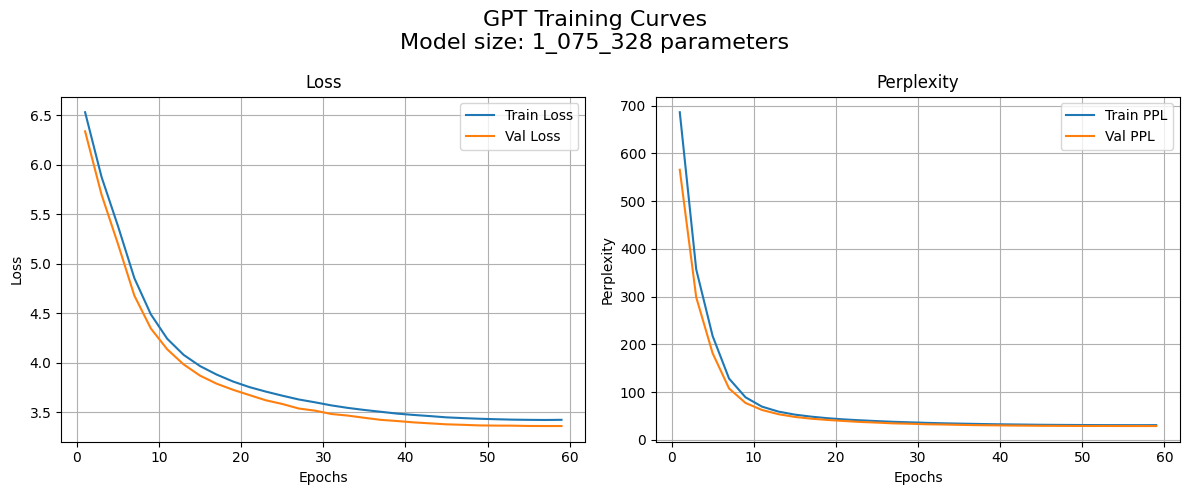

In [5]:
# make train_loss, train_ppl, val_ppl, val_loss and epochs into a DataFrame
history = train_results["history"]
history_df = pd.DataFrame(history)

display(history_df.head())
display(history_df.tail())

plt.figure(figsize=(12, 5))
plt.suptitle(f"GPT Training Curves\nModel size: {model_size:_} parameters", fontsize=16)
# loss 
plt.subplot(1, 2, 1)
plt.plot(history_df['epoch'], history_df["train_loss"], label="Train Loss")
plt.plot(history_df['epoch'], history_df["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.xticks(history_df['epochs'][::int(len(history_df['epochs'])//9)+1])  
plt.title("Loss")
plt.legend()
plt.grid()

# perplexity
plt.subplot(1, 2, 2)
plt.plot(history_df['epoch'], history_df["train_ppl"], label="Train PPL")
plt.plot(history_df['epoch'], history_df["val_ppl"], label="Val PPL")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
# plt.xticks(history_df['epochs'][::int(len(history_df['epochs'])//9)+1])  
plt.title("Perplexity")
plt.legend()
plt.grid()
plt.tight_layout()

# save the training plot
plt.savefig(os.path.join(RESULTS_DIR, f"GPT_training_plot.png")) 

plt.show()

In [6]:
# final evaluation on the test set
test_nll = evaluate(model, test_loader, cfg_train.device)
test_ppl = np.exp(test_nll)

val_ppl = train_results["best_val_ppl"]
train_ppl = train_results["best_train_ppl"]

val_nll = torch.log(torch.tensor(val_ppl)).item()
train_nll = torch.log(torch.tensor(train_ppl)).item()

# display in a DataFrame
test_results_df = pd.DataFrame({
    "split": ["train", "val", "test"],
    "loss(NLL)": [train_nll, val_nll, test_nll],
    "perplexity": [train_ppl, val_ppl, test_ppl],
})
display(test_results_df)

,split,loss(NLL),perplexity
0,train,3.421623,30.619076
1,val,3.358784,28.754210
2,test,3.266540,26.220469


In [7]:
# save test results
test_results_filename = os.path.join(RESULTS_DIR, "test_performance_results.csv")
test_results_df.to_csv(test_results_filename, index=False)
print(f"test results saved to {test_results_filename}")

test results saved to ../results/GPT/test_performance_results.csv


### generate text from the trained model

In [8]:
# get a batch from validation set and generate text
batch_gen = 5
max_new_tokens = 100

unified_context = " ".join(test_text.split()[:3])
unified_context_ids = encode(unified_context, add_special_tokens=False).ids
context_len = len(unified_context_ids)

context_ids_batch, _ = next(iter(test_loader))
# replace first row with unified_context_ids
context_ids_batch[0, :context_len] = torch.tensor(unified_context_ids[:block_size], dtype=torch.long)

context_ids_batch = context_ids_batch.to(cfg_train.device, non_blocking=True)
# generate text from the model
generated_text = model.generate(context_ids_batch[:batch_gen, :context_len], max_new_tokens=max_new_tokens, temperature=0.9, top_k=20)

print(f"used tokenizer: bytelevel_bpe, merges: {n_merges}, min_freq: {min_freq}")
print(f">>>> <context>\n", "-" *20, "\n<<<< <generated_text>")
for i, text in enumerate(generated_text):
    print("\n", "-" * 80)
    print(">>>>", decode(text[:context_len].tolist()))
    print("-" * 20)
    print("<<<< ", decode(text[context_len:].tolist()))
    if i + 1 >= batch_gen:
        break

used tokenizer: bytelevel_bpe, merges: 800, min_freq: 2
>>>> <context>
 -------------------- 
<<<< <generated_text>

 --------------------------------------------------------------------------------
>>>>  shall the lovers
--------------------
<<<<  .



First Citizen
O, my lord!



CThether you?

First Witch
You may the tradies?



MACBETH
If you?


CBETH
Ay, what'st, I have it will; I may
aesar will do soldier to know. I, I


CASSIUS


 --------------------------------------------------------------------------------
>>>> t dragon
--------------------
<<<<  !


MIAGO
Stay, I'll be the wised,
And for a mother's cratisonum:
There they have apposal, as to his hours,
And sick-s the crike's drike
Of pal and the praility
With his chens, the money,
The fict of

 --------------------------------------------------------------------------------
>>>>  should look their sham
--------------------
<<<<  e?



Second Soldier
Thy body, and the fitions with melse of his bad
As the turns of the free, as

In [9]:
# save generation results to a text file
gen_results_filename = os.path.join(RESULTS_DIR, "text_generation_results.txt")
with open(gen_results_filename, "w", encoding="utf-8") as f:
    f.write(f"used tokenizer: bytelevel_bpe, merges: {n_merges}, min_freq: {min_freq}\n")
    f.write(f">>>> <context>\n")
    f.write("-" * 20 + "\n")
    f.write(f"<<<< <generated_text>\n")
    for i, text in enumerate(generated_text):
        f.write("\n" + "-" * 80 + "\n")
        f.write(">>>> " + decode(text[:context_len].tolist()) + "\n")
        f.write("-" * 20 + "\n")
        f.write("<<<< " + decode(text[context_len:].tolist()) + "\n")
        if i + 1 >= batch_gen:
            break
print(f"generation results saved to {gen_results_filename}")

generation results saved to ../results/GPT/text_generation_results.txt
